## Desafio de Machine Learning Avançado


A base de dados "HR_Abandono.csv" contém um conjunto de características sobre colaboradores de uma empresa, tais como:  

* satisfaction_level - nível de satisfação do colaborador com a empresa
* last_evaluation - nota da última avaliação
* average_montly_hours -  média de horas mensais trabalhadas
* time_spend_company - tempo de empresa
* Work_accident - acidente de trabalho
* left - deixou a empresa
* promotion_last_5years - recebeu promoção nos últimos 5 anos
* salary - salário
* num_project - número de projetos
* depto - departamento

## Objetivo
Construir um modelo preditivo. O objetivo do modelo será prever, com base nas outras características (como nível de satisfação, avaliação, horas trabalhadas, etc.), se um funcionário irá pertencer à classe '1' (abandono) ou à classe '0' (permanência).

# Passo 1
O primeiro passo é a análise da consistência dos dados. Utilize a biblioteca do Pandas para subir a base de dados e realizar validações sobre os dados, tais como a verificação de valores nulos, duplicados, identificação de outliers e realizar tratativas caso seja necessário. Não se esqueça de explicar cada etapa de transformação aplicada aos dados caso seja necessário.

Após realizar a tratativa dos dados, é necessário namorar os dados e caprichar na análise estatística descritiva, como por exemplo entender a média das variáveis qualitativas, entre outras.

In [51]:
# Importando as bibliotecas necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import chi2_contingency
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import pearsonr
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support



# Configurações de exibição
sns.set(style="whitegrid")

In [52]:
# Carregando os dados
df = pd.read_csv('HR_Abandono.csv', sep=';')
df.head()

,id,satisfaction_level,last_evaluation,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,salary,num_project,depto
0,1,"0,38","0,53",157,3,0,1,0,low,2,sales
1,2,"0,8","0,86",262,6,0,1,0,medium,5,sales
2,3,"0,11","0,88",272,4,0,1,0,medium,6,sales
3,4,"0,72","0,87",223,5,0,1,0,low,5,sales
4,5,"0,37","0,52",159,3,0,1,0,low,2,sales


In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     14999 non-null  int64 
 1   satisfaction_level     14999 non-null  object
 2   last_evaluation        14999 non-null  object
 3   average_montly_hours   14999 non-null  int64 
 4   time_spend_company     14999 non-null  int64 
 5   Work_accident          14999 non-null  int64 
 6   left                   14999 non-null  int64 
 7   promotion_last_5years  14999 non-null  int64 
 8   salary                 14999 non-null  object
 9   num_project            14999 non-null  int64 
 10  depto                  14999 non-null  object
dtypes: int64(7), object(4)
memory usage: 1.3+ MB


In [54]:
# Trocando a vírgula por ponto em colunas numéricas
colunas = ['satisfaction_level', 'last_evaluation']
for coluna in colunas:
    df[coluna] = df[coluna].str.replace(',', '.').astype(float)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     14999 non-null  int64  
 1   satisfaction_level     14999 non-null  float64
 2   last_evaluation        14999 non-null  float64
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   salary                 14999 non-null  object 
 9   num_project            14999 non-null  int64  
 10  depto                  14999 non-null  object 
dtypes: float64(2), int64(7), object(2)
memory usage: 1.3+ MB


In [55]:
df.head()

,id,satisfaction_level,last_evaluation,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,salary,num_project,depto
0,1,0.38,0.53,157,3,0,1,0,low,2,sales
1,2,0.80,0.86,262,6,0,1,0,medium,5,sales
2,3,0.11,0.88,272,4,0,1,0,medium,6,sales
3,4,0.72,0.87,223,5,0,1,0,low,5,sales
4,5,0.37,0.52,159,3,0,1,0,low,2,sales


In [56]:
# Verificando se há valores nulos
print("Valores nulos por coluna:")
display(df.isnull().sum())

# Verificando linhas duplicadas
print(f"\nNúmero de linhas duplicadas: {df.duplicated().sum()}")

Valores nulos por coluna:


id                       0
satisfaction_level       0
last_evaluation          0
average_montly_hours     0
time_spend_company       0
Work_accident            0
left                     0
promotion_last_5years    0
salary                   0
num_project              0
depto                    0
dtype: int64


Número de linhas duplicadas: 0


Os dados de abandono não possuem valores ausentes e nem linhas duplicadas.

In [57]:
df.describe()

,id,satisfaction_level,last_evaluation,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,num_project
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,7500.000000,0.612823,0.716102,201.083672,3.407027,0.144610,0.238083,0.021268,3.785986
std,4329.982679,0.248655,0.171169,50.182121,1.176120,0.351719,0.425924,0.144281,1.194539
min,1.000000,0.010000,0.360000,96.000000,2.000000,0.000000,0.000000,0.000000,2.000000
25%,3750.500000,0.440000,0.560000,156.000000,3.000000,0.000000,0.000000,0.000000,3.000000
50%,7500.000000,0.640000,0.720000,200.000000,3.000000,0.000000,0.000000,0.000000,4.000000
75%,11249.500000,0.820000,0.870000,245.000000,4.000000,0.000000,0.000000,0.000000,5.000000
max,14999.000000,1.000000,1.000000,810.000000,6.000000,1.000000,1.000000,1.000000,6.000000


* A média da satisfação dos funcionários é 0.61.
* Os funcionários trabalham em média 201 horas por mês.
* O tempo médio na empresa é de 3.4 anos.
* Número médio de projetos por funcionário é de 3.79.

In [58]:
salary = df['salary'].value_counts()
salary_percentual = round((salary / len(df) * 100),2)
salary_df = pd.DataFrame({'Quantidade': salary, 'Percentual (%)': salary_percentual})
salary_df

,Quantidade,Percentual (%)
salary,,
low,7316,48.78
medium,6446,42.98
high,1237,8.25


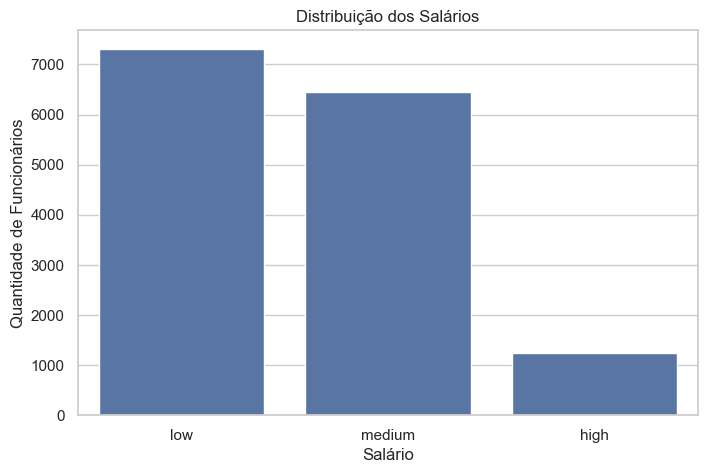

In [59]:
# Visualizando a distribuição dos salários
plt.figure(figsize=(8,5))
sns.countplot(x='salary', data=df, order=salary.index)
plt.title('Distribuição dos Salários')
plt.xlabel('Salário')
plt.ylabel('Quantidade de Funcionários')
plt.show()

* 48.78% dos funcionários recebem salários considerados baixos, enquanto 8.25% tem salários altos.

In [60]:
depto = df['depto'].value_counts()
depto_percentual = round((depto / len(df) * 100),2)
depto_df = pd.DataFrame({'Quantidade': depto, 'Percentual (%)': depto_percentual})
depto_df

,Quantidade,Percentual (%)
depto,,
sales,4140,27.60
technical,2720,18.13
support,2229,14.86
IT,1227,8.18
product_mng,902,6.01
marketing,858,5.72
RandD,787,5.25
accounting,767,5.11
hr,739,4.93


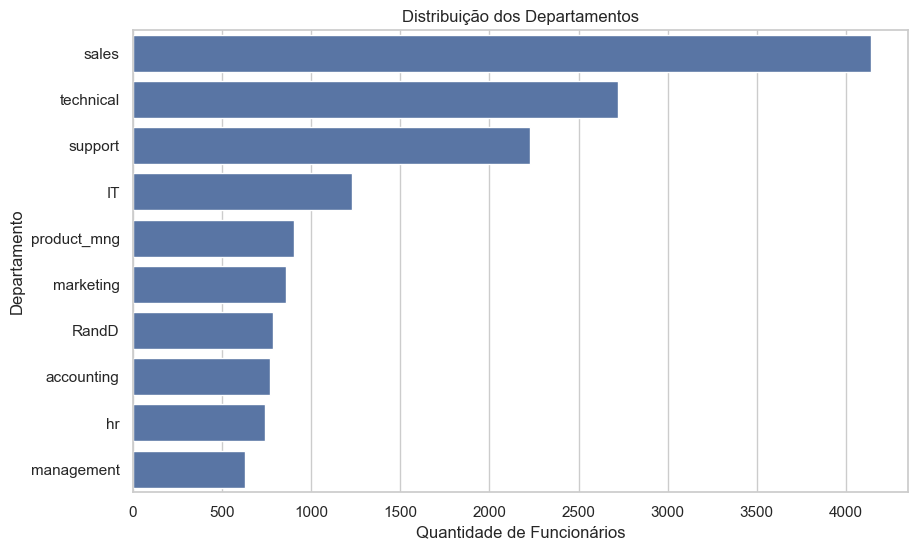

In [61]:
# Visualizando a distribuição dos departamentos
plt.figure(figsize=(10,6))
sns.countplot(y='depto', data=df, order=depto.index)
plt.title('Distribuição dos Departamentos')
plt.xlabel('Quantidade de Funcionários')
plt.ylabel('Departamento')
plt.show()

O departamento com maior número de funcionários é vendas (27.60%), seguido da área técnica (18.13%). Já o departamento com menor número de funcionário é o gerecial, com 630 gerentes.  

# 2 - Análise Exploratória dos Dados
Utilize a biblioteca do matplotlib e seaborn para realizar uma bela análise de dados com storytelling. Faça perguntas para os dados e conte uma história, utilizando gráficos e realizando inferências para explicar cada uma das análises. A dica aqui é não economizar no uso de gráficos!

### Nível de Satisfação

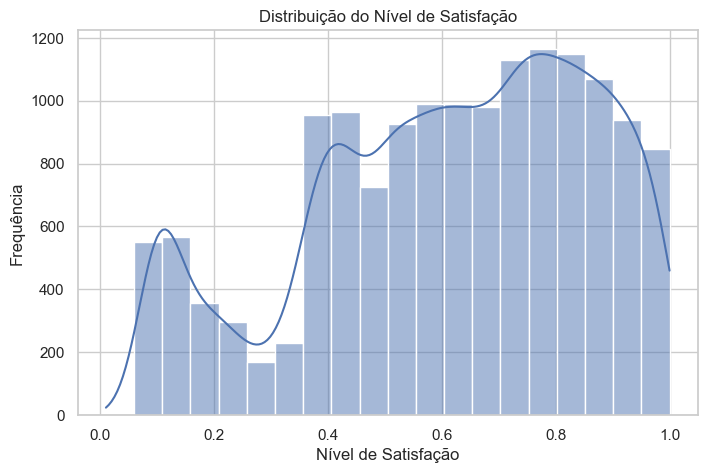

In [62]:
# Distribuição do nível de satisfação
plt.figure(figsize=(8,5))
sns.histplot(df['satisfaction_level'], bins=20, kde=True)
plt.title('Distribuição do Nível de Satisfação')
plt.xlabel('Nível de Satisfação')
plt.ylabel('Frequência')
plt.show()

### Última Avaliação

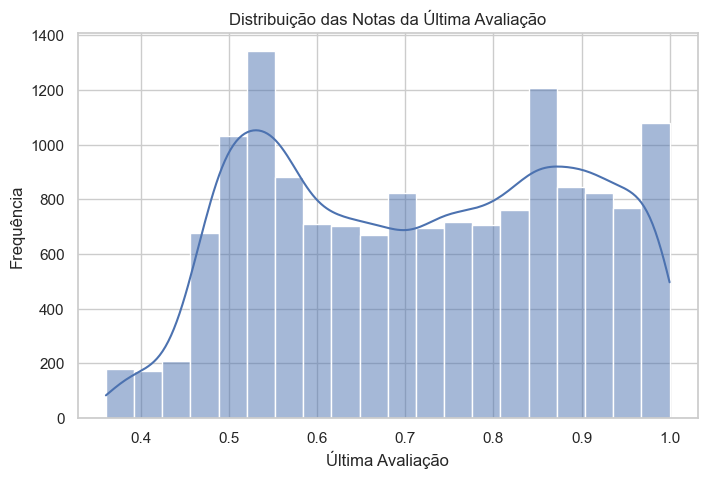

In [63]:
# Distribuição das notas da última avaliação
plt.figure(figsize=(8,5))
sns.histplot(df['last_evaluation'], bins=20, kde=True)
plt.title('Distribuição das Notas da Última Avaliação')
plt.xlabel('Última Avaliação')
plt.ylabel('Frequência')
plt.show()

### Média de Horas Trabalhadas por Mês

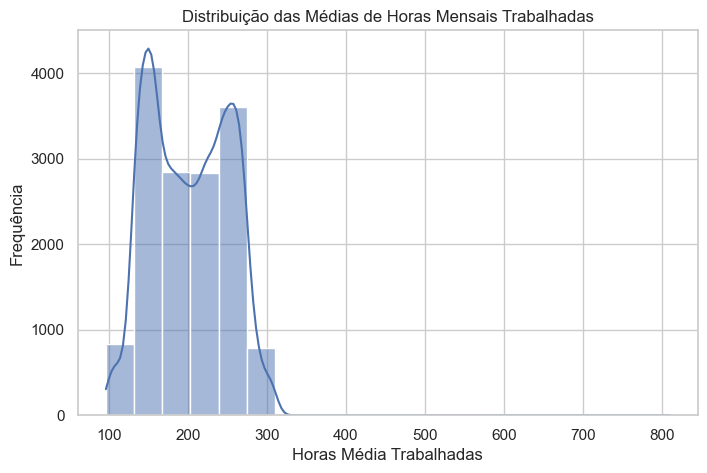

In [64]:
# Distribuição das Horas Trabalhadas
plt.figure(figsize=(8,5))
sns.histplot(df['average_montly_hours'], bins=20, kde=True)
plt.title('Distribuição das Médias de Horas Mensais Trabalhadas')
plt.xlabel('Horas Média Trabalhadas')
plt.ylabel('Frequência')
plt.show()

### Tempo de Empresa

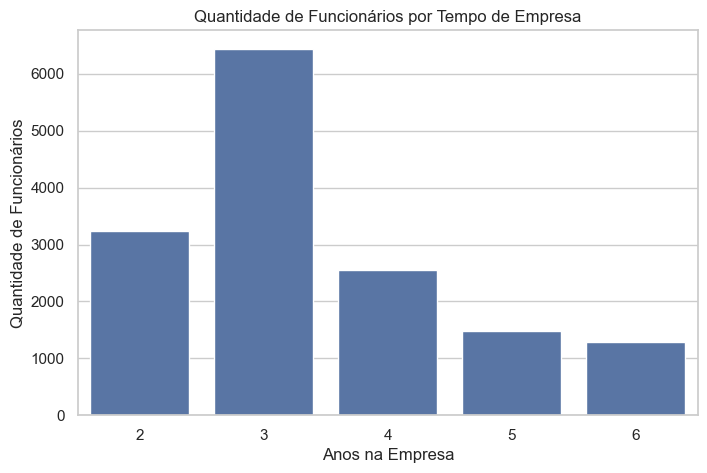

In [65]:
# Distribuição do tempo na empresa
plt.figure(figsize=(8,5))
sns.countplot(x='time_spend_company', data=df)
plt.title('Quantidade de Funcionários por Tempo de Empresa')
plt.xlabel('Anos na Empresa')
plt.ylabel('Quantidade de Funcionários')
plt.show()

### Acidente de Trabalho

In [66]:
acidente = df['Work_accident'].value_counts()
acidente_percentual = round((acidente / len(df) * 100),2)
acidente_df = pd.DataFrame({'Quantidade': acidente, 'Percentual (%)': acidente_percentual})


acidente_df.index = acidente_df.index.map({0: 'Não', 1: 'Sim'})
acidente_df.index.name = 'Acidente de Trabalho'
acidente_df

,Quantidade,Percentual (%)
Acidente de Trabalho,,
Não,12830,85.54
Sim,2169,14.46


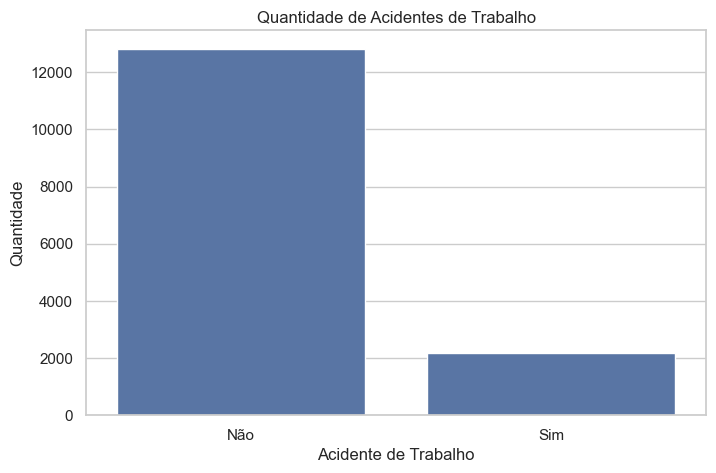

In [67]:
# Distribuição da Quantidade de acidentes de trabalho
plt.figure(figsize=(8,5))
sns.barplot(x=acidente_df.index, y='Quantidade', data=acidente_df)
plt.title('Quantidade de Acidentes de Trabalho')
plt.xlabel('Acidente de Trabalho')
plt.ylabel('Quantidade')
plt.show()

### Promoção

In [68]:
# Proporção de funcionarios que abandoram a empresa
promocao = df['promotion_last_5years'].value_counts()
promocao_percentual = round((promocao / len(df) * 100),2)
promocao_df = pd.DataFrame({'Quantidade': promocao, 'Percentual (%)': promocao_percentual})
promocao_df

# Renomeando os valores da coluna 'left'
promocao_df.index = promocao_df.index.map({0: 'Não', 1: 'Sim'})
promocao_df.index.name = 'Promoção nos Últimos 5 Anos'
promocao_df

,Quantidade,Percentual (%)
Promoção nos Últimos 5 Anos,,
Não,14680,97.87
Sim,319,2.13


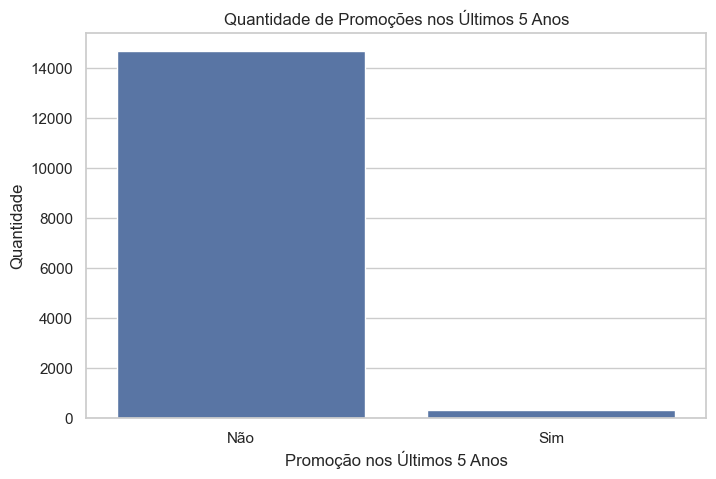

In [69]:
# Distribuição dos funcionários que receberam promoção no último 5 anos
plt.figure(figsize=(8,5))
sns.barplot(x=promocao_df.index, y='Quantidade', data=promocao_df)
plt.title('Quantidade de Promoções nos Últimos 5 Anos')
plt.xlabel('Promoção nos Últimos 5 Anos')
plt.ylabel('Quantidade')
plt.show()

### Número de projetos

In [70]:
projetos = df['num_project'].value_counts()
projetos_percentual = round((projetos / len(df) * 100),2)
projetos_df = pd.DataFrame({'Quantidade': projetos, 'Percentual (%)': projetos_percentual})
projetos_df.index.name = 'Número de Projetos'
projetos_df

,Quantidade,Percentual (%)
Número de Projetos,,
4,4365,29.10
3,4055,27.04
5,2761,18.41
2,2388,15.92
6,1430,9.53


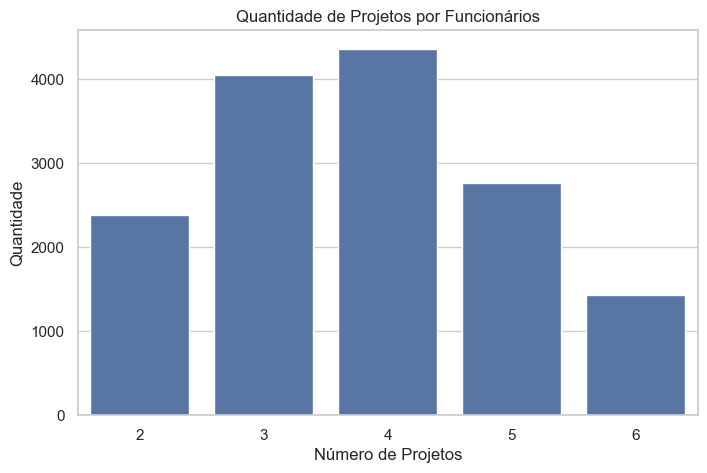

In [71]:
# Distribuição dos números de projetos
plt.figure(figsize=(8,5))
sns.countplot(x='num_project', data=df)
plt.title('Quantidade de Projetos por Funcionários')
plt.xlabel('Número de Projetos')
plt.ylabel('Quantidade')
plt.show()

### Abandono

In [72]:
# Proporção de funcionarios que abandoram a empresa
abandono = df['left'].value_counts()
abandono_percentual = round((abandono / len(df) * 100),2)
abandono_df = pd.DataFrame({'Quantidade': abandono, 'Percentual (%)': abandono_percentual})
abandono_df

# Renomeando os valores da coluna 'left'
abandono_df.index = abandono_df.index.map({0: 'Não', 1: 'Sim'})
abandono_df.index.name = 'Abandono'
abandono_df

,Quantidade,Percentual (%)
Abandono,,
Não,11428,76.19
Sim,3571,23.81


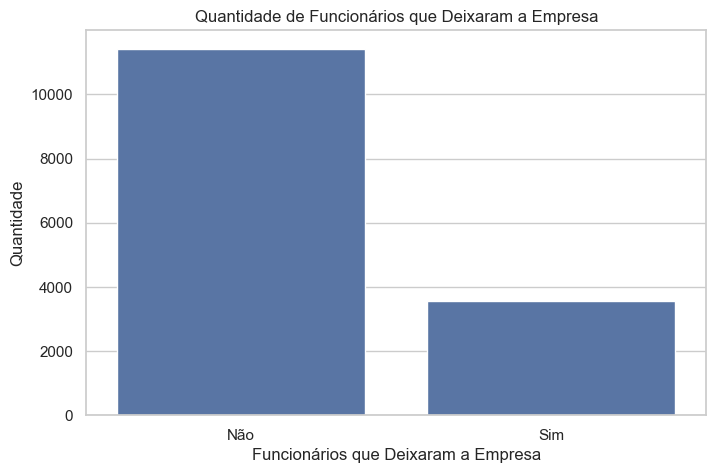

In [73]:
# Distribuição dos funcionários que deixaram a empresa
plt.figure(figsize=(8,5))
sns.barplot(y='Quantidade', x=abandono_df.index, data=abandono_df)
plt.title('Quantidade de Funcionários que Deixaram a Empresa')
plt.xlabel('Funcionários que Deixaram a Empresa')
plt.ylabel('Quantidade')
plt.show()

# 3 - Teste de Hipótese

In [74]:
dados = df.copy()
dados['left'] = dados['left'].map({0: 'Permaneceu', 1: 'Saiu'})

### O nível de satisfação interfere na decisão de deixar a empresa?
* H0: o nível de satisfação é igual para quem saiu e quem permanceu
* H1: rejeita H0

Para isso vamos utilizar o teste t.


In [75]:
satisfacao_ficou = df[df['left'] == 0]['satisfaction_level']
satisfacao_saiu = df[df['left'] == 1]['satisfaction_level']

t_stat_satisfacao, p_value_satisfacao = stats.ttest_ind(satisfacao_ficou,
                                                        satisfacao_saiu,
                                                        equal_var=False)

print(f'Estatistica t: {t_stat_satisfacao}, p-valor: {p_value_satisfacao}')

Estatistica t: 46.635970904157084, p-valor: 0.0


Com o resultado do p-valor, rejeitamos H0. Desta forma, o nível de satisfação interfere na decisão de deixar a empresa.

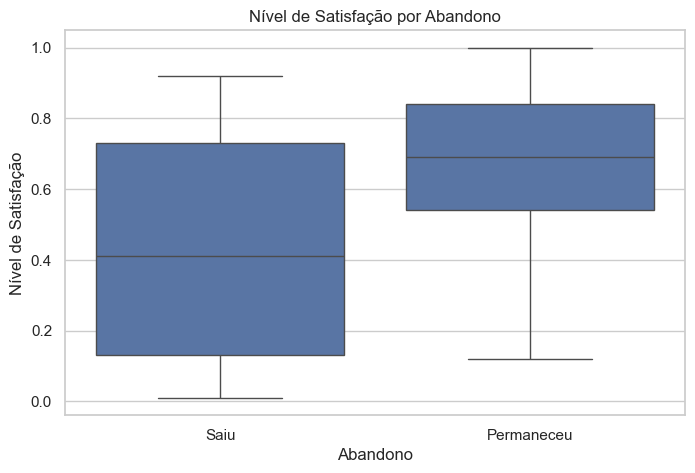

In [76]:
# Boxplot o nível de satisfação
plt.figure(figsize=(8,5))
sns.boxplot(x='left', y='satisfaction_level', data=dados)
plt.title('Nível de Satisfação por Abandono')
plt.xlabel('Abandono')
plt.ylabel('Nível de Satisfação')
plt.show()

### A nota da última avaliação influencia no abandono?
* H0: não há diferença entre as avaliações para influenciar no abandono
* H1: rejeita H0

Vamos utilizar o test t

In [77]:
avaliacao_ficou = df[df['left'] == 0]['last_evaluation']
avaliacao_saiu = df[df['left'] == 1]['last_evaluation']

t_stat_avaliacao, p_value_avaliacao = stats.ttest_ind(avaliacao_ficou,
                                                      avaliacao_saiu,
                                                      equal_var=False)

print(f'Estatistica t: {t_stat_avaliacao}, p-valor: {p_value_avaliacao}')

Estatistica t: -0.7253423415891874, p-valor: 0.46827496132319124


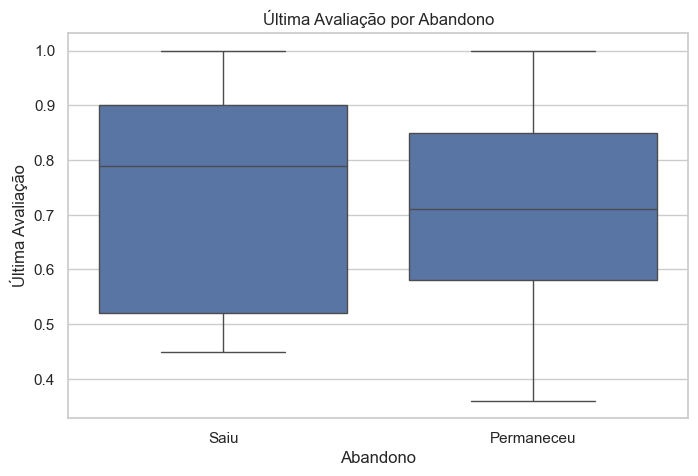

In [78]:
plt.figure(figsize=(8,5))
sns.boxplot(x='left', y='last_evaluation', data=dados)
plt.title('Última Avaliação por Abandono')
plt.xlabel('Abandono')
plt.ylabel('Última Avaliação')
plt.show()

### A Quantidade de horas trabalhadas influencia no abandono?
* H0: a quantidade de horas não interfere na decisão de deixar a empresa
* H1: rejeita H0

Para esse teste vamos utilizar o teste t:

In [79]:
hora_ficou = df[df['left'] == 0]['average_montly_hours']
hora_saiu = df[df['left'] == 1]['average_montly_hours']

t_stat_hora, p_value_hora = stats.ttest_ind(hora_ficou,
                                            hora_saiu,
                                            equal_var=False)

print(f'Estatistica t: {t_stat_hora}, p-valor: {p_value_hora}')

Estatistica t: -7.573904010092895, p-valor: 4.312094345847756e-14


p-valor menor que 0.05, portanto rejeitamos H0. As horas trabalhadas interfere na decisão de deixar a empresa.

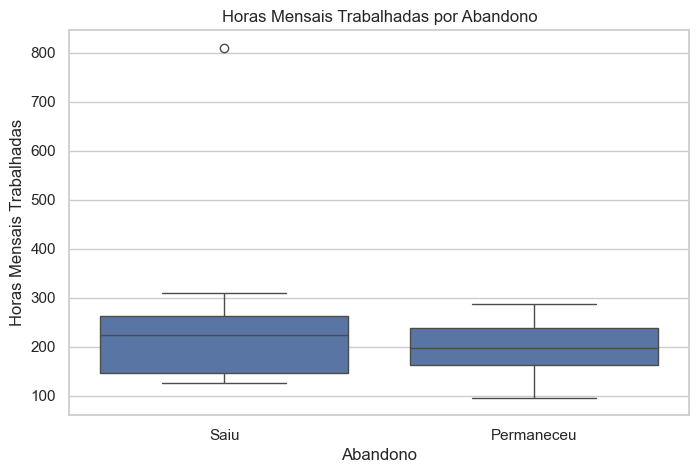

In [80]:
plt.figure(figsize=(8,5))
sns.boxplot(x='left', y='average_montly_hours', data=dados)
plt.title('Horas Mensais Trabalhadas por Abandono')
plt.xlabel('Abandono')
plt.ylabel('Horas Mensais Trabalhadas')
plt.show()

### O tempo na empresa influencia no abandono?
* H0: o tempo na empresa não interfere na decisão de abandono
* H1: rejeita H0

Para esse teste vamos utilizar o teste t:

In [81]:
spend_ficou = df[df['left'] == 0]['time_spend_company']
spend_saiu = df[df['left'] == 1]['time_spend_company']

t_stat_spend, p_value_spend = stats.ttest_ind(spend_ficou,
                                              spend_saiu,
                                              equal_var=False)

print(f'Estatistica t: {t_stat_spend}, p-valor: {p_value_spend}')

Estatistica t: -31.1016833357108, p-valor: 2.335440878316491e-199


O p-valor é menor que 0.05, dessa forma rejeitamos H0. O tempo na empresa interfere na decisão de abandono.

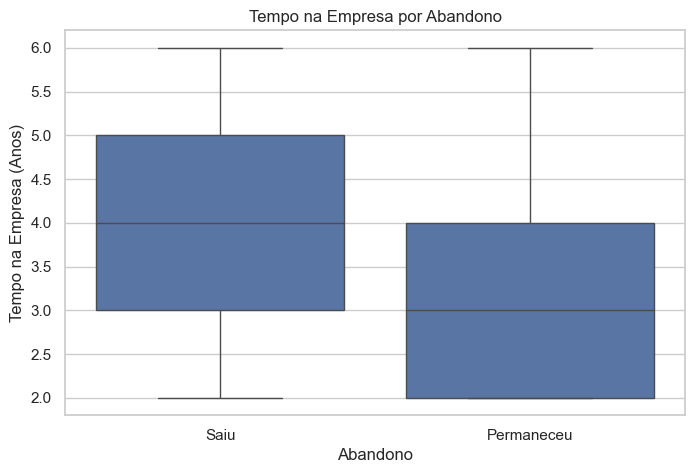

In [82]:
plt.figure(figsize=(8,5))
sns.boxplot(x='left', y='time_spend_company', data=dados)
plt.title('Tempo na Empresa por Abandono')
plt.xlabel('Abandono')
plt.ylabel('Tempo na Empresa (Anos)')
plt.show()

### O numero de acidentes de trabalho influencia no abandono?

* H0: Não há relação entre o acidente de trabalho e o abandono
* H1: rejeita H0

Para verificar a relação dessas duas variáveis vamos utilizar Q-quadrado.

In [83]:
# Teste Q-quadrado
acidente_abandono = pd.crosstab(df['Work_accident'], df['left'])
chi2_acidente, p_value_acidente, dof_acidente, expected_acidente = stats.chi2_contingency(acidente_abandono)
print(f'Q-quadrado: {chi2_acidente}. p-valor: {p_value_acidente} ')

Q-quadrado: 357.5623604097228. p-valor: 9.55823958002199e-80 


O p-valor deu menor que 0.05, portanto rejeita H0. Há relação entre o acidente de trabalho e o abandono.

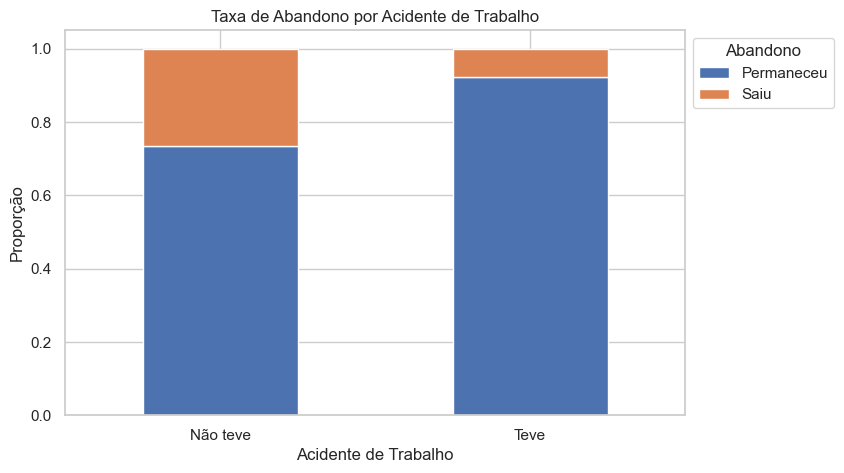

In [84]:
acidente_abandono = pd.crosstab(df['Work_accident'], df['left'], normalize='index')
acidente_abandono.index = acidente_abandono.index.map({0: 'Não teve', 1: 'Teve'})

plt.figure(figsize=(8,5))
acidente_abandono.plot(kind='bar', stacked=True, ax=plt.gca())  
plt.title('Taxa de Abandono por Acidente de Trabalho')
plt.xlabel('Acidente de Trabalho')
plt.ylabel('Proporção')
plt.xticks(rotation=0)
plt.legend(title='Abandono', labels=['Permaneceu', 'Saiu'],  bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

### Quem foi promovido nos ultimos 5 anos não abandonam a empresa?
* H0: Não há relação entre a promoção e o abandono
* H1: rejeita H0

Para verificar a relação dessas duas variáveis vamos utilizar Q-quadrado.

In [85]:
# Teste Q-quadrado
promo_abandono = pd.crosstab(df['promotion_last_5years'], df['left'])
chi2_promo, p_value_promo, dof_promo, expected_promo = stats.chi2_contingency(promo_abandono)
print(f'Q-quadrado: {chi2_promo}. p-valor: {p_value_promo} ')

Q-quadrado: 56.26162726484021. p-valor: 6.344155457918697e-14 


Rejeitamos H0 com o p-valor. Portanto, há relação entre a promoção e o abandono dos funcionários.

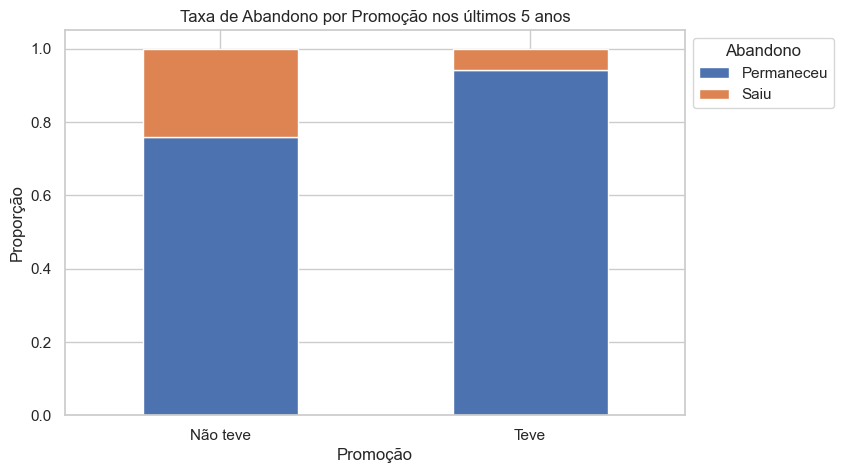

In [86]:
# Gráfico empilhado entre promoção e abandono
promo_abandono = pd.crosstab(df['promotion_last_5years'], df['left'], normalize='index')
promo_abandono.index = promo_abandono.index.map({0: 'Não teve', 1: 'Teve'})

plt.figure(figsize=(8,5))
promo_abandono.plot(kind='bar', stacked=True, ax=plt.gca())  
plt.title('Taxa de Abandono por Promoção nos últimos 5 anos')
plt.xlabel('Promoção')
plt.ylabel('Proporção')
plt.xticks(rotation=0)
plt.legend(title='Abandono', labels=['Permaneceu', 'Saiu'],  bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

### O salário influencia no abandono?
* H0: Não há relação entre o salário e o abandono
* H1: rejeita H0

Para verificar a relação dessas duas variáveis vamos utilizar Q-quadrado.

In [87]:
# Teste Q-quadrado
salario_abandono = pd.crosstab(df['salary'], df['left'])
chi2_salario, p_value_salario, dof_salario, expected_salario = stats.chi2_contingency(salario_abandono)
print(f'Q-quadrado: {chi2_salario}. p-valor: {p_value_salario}')

Q-quadrado: 381.22504706621066. p-valor: 1.652086749295958e-83


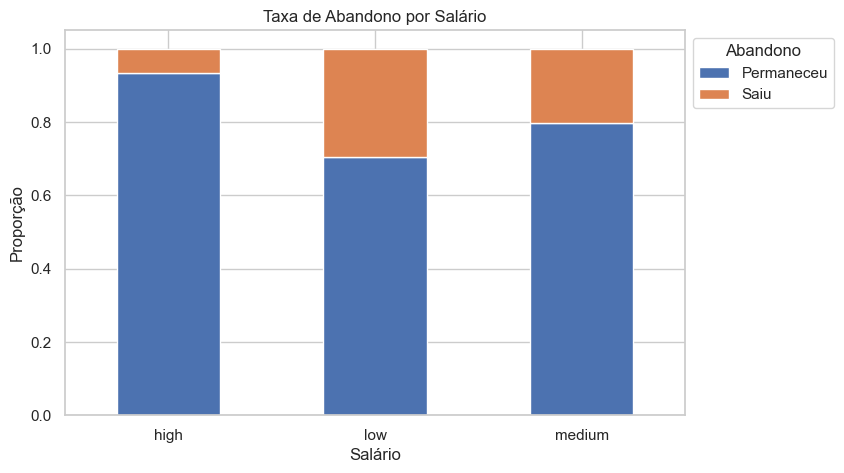

In [88]:
# Gráfico empilhado da taxa de abandono por salário
plt.figure(figsize=(8,5))
salario_abandono = pd.crosstab(df['salary'], df['left'], normalize='index')
salario_abandono.plot(kind='bar', stacked=True, ax=plt.gca())  
plt.title('Taxa de Abandono por Salário')
plt.xlabel('Salário')
plt.ylabel('Proporção')
plt.xticks(rotation=0)
plt.legend(title='Abandono', labels=['Permaneceu', 'Saiu'],  bbox_to_anchor=(1, 1), loc='upper left')
plt.show()


### Quem tem mais projetos abandonam a empresa?
* H0: o número de projeto não interfere na decisão de abandono
* H1: rejeita H0

Para esse teste vamos utilizar o teste t:

In [89]:
projeto_ficou = df[df['left'] == 0]['num_project']
projeto_saiu = df[df['left'] == 1]['num_project']

t_stat_projeto, p_value_projeto = stats.ttest_ind(projeto_ficou,
                                                  projeto_saiu,
                                                  equal_var=False)

print(f'Estatistica t: {t_stat_projeto}, p-valor: {p_value_projeto}')


Estatistica t: 0.09489924856746322, p-valor: 0.9243992478943522


O p-valor é maior que 0.05, então aceitamos H0. A variável em análise não interfere na decisão de deixar a empresa.

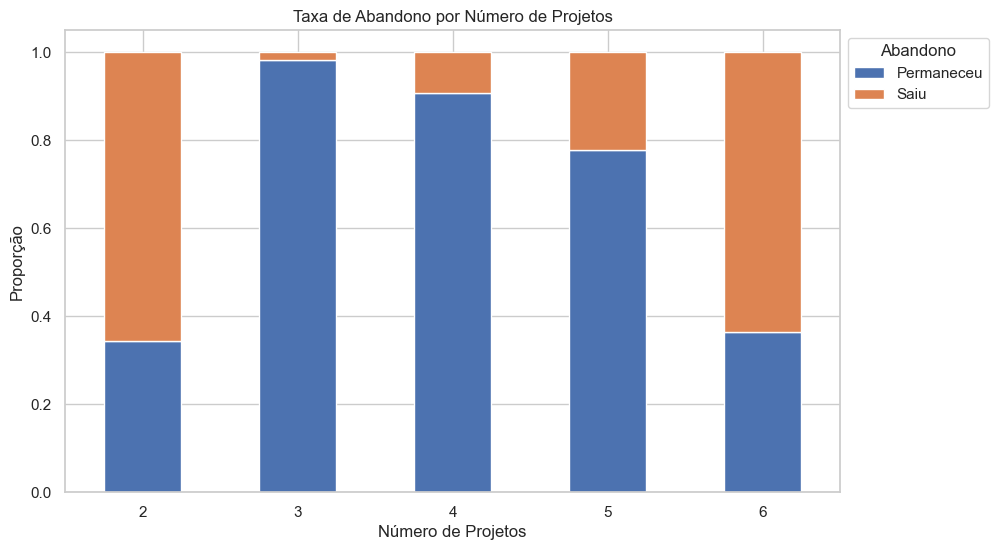

In [90]:
# Gráfico empilhado da taxa de abandono por projetos
plt.figure(figsize=(10,6))
projetos_abandono = pd.crosstab(df['num_project'], df['left'], normalize='index')
projetos_abandono.plot(kind='bar', stacked=True, ax=plt.gca())  
plt.title('Taxa de Abandono por Número de Projetos')
plt.xlabel('Número de Projetos')
plt.ylabel('Proporção')
plt.xticks(rotation=360)
plt.legend(title='Abandono', labels=['Permaneceu', 'Saiu'],  bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

### O departamento interfere na decisão de deixar a empresa?

* H0: Não há relação entre o departamento e o abandono
* H1: rejeita H0

Para verificar a relação dessas duas variáveis vamos utilizar Q-quadrado.

In [91]:
# Teste Q-quadrado
depto_abandono = pd.crosstab(df['depto'], df['left'])
chi2_depto, p_value_depto, dof_depto, expected_depto = stats.chi2_contingency(depto_abandono)
print(f'Q-quadrado: {chi2_depto}. p-valor: {p_value_depto}')

Q-quadrado: 86.82547426790299. p-valor: 7.042130463822518e-15


P-valor é menor que 0.05. Rejeitamos H0.

Com isso, temos que o departamento interfere na decisão de deixar a empresa.

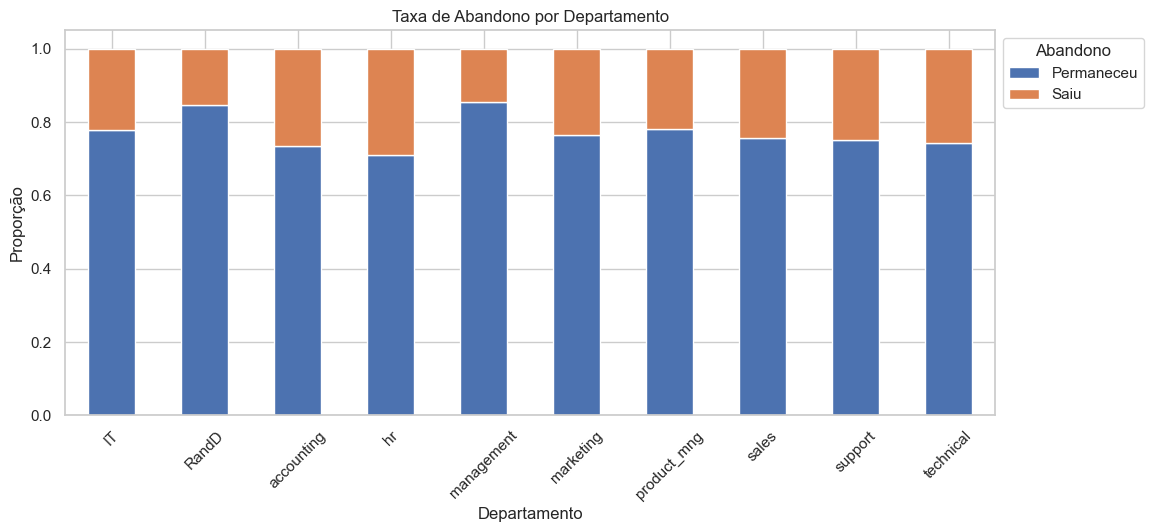

In [92]:
# Gráfico empilhado da taxa de abandono por departamento
plt.figure(figsize=(12,5))
dept_abandono = pd.crosstab(df['depto'], df['left'], normalize='index')
dept_abandono.plot(kind='bar', stacked=True, ax=plt.gca())  
plt.title('Taxa de Abandono por Departamento')
plt.xlabel('Departamento')
plt.ylabel('Proporção')
plt.xticks(rotation=45)
plt.legend(title='Abandono', labels=['Permaneceu', 'Saiu'], bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

# 4 - Definição do Tipo de Modelo que deve ser utilizado
Para prever se os funcionários irão abandonar a empresa ou não, será utilizado os modelos de classificação.

In [93]:
# Features
X = df.drop('left', axis=1)

# Target
y = df['left']

In [94]:
# Padronizando e Normalizando as variáveis categóricas
X = pd.get_dummies(X, columns=['salary', 'depto'], drop_first=True)

In [95]:
# Padronizando as variáveis numéricas
scaler = StandardScaler()
X[['satisfaction_level', 'last_evaluation', 'average_montly_hours', 'time_spend_company']] = scaler.fit_transform(X[['satisfaction_level', 'last_evaluation', 'average_montly_hours', 'time_spend_company']])   
X.head()

,id,satisfaction_level,last_evaluation,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,num_project,salary_low,salary_medium,depto_RandD,depto_accounting,depto_hr,depto_management,depto_marketing,depto_product_mng,depto_sales,depto_support,depto_technical
0,1,-0.936361,-1.087275,-0.878503,-0.346088,0,0,2,True,False,False,False,False,False,False,False,True,False,False
1,2,0.752784,0.840707,1.213945,2.204758,0,0,5,False,True,False,False,False,False,False,False,True,False,False
2,3,-2.022240,0.957554,1.413226,0.504194,0,0,6,False,True,False,False,False,False,False,False,True,False,False
3,4,0.431042,0.899131,0.436750,1.354476,0,0,5,True,False,False,False,False,False,False,False,True,False,False
4,5,-0.976579,-1.145699,-0.838647,-0.346088,0,0,2,True,False,False,False,False,False,False,False,True,False,False


In [96]:
# Dividindo o modelo em conjunto de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 5 - Modelos Utilizados
Construa um modelo preditivo com os algoritmos disponíveis na biblioteca do Scikit-Learn e explique qual algoritmo você escolheu utilizar para solucionar o problema definido. Não se esqueça de esclarecer os hiperparâmetros utilizados.

### Regressão Logística

In [97]:
modelo_logreg = LogisticRegression()
modelo_logreg.fit(X_train, y_train)

y_pred_rl = modelo_logreg.predict(X_test)

# Avaliando o modelo de Regressão Logística
acc = accuracy_score(y_test, y_pred_rl)
print(f'Acurácia do modelo Regressão Logística: {acc:.4f}\n')
print("Relatório de Classificação - Regressão Logística:")
print(classification_report(y_test, y_pred_rl))

Acurácia do modelo Regressão Logística: 0.7910

Relatório de Classificação - Regressão Logística:
              precision    recall  f1-score   support

           0       0.83      0.91      0.87      2294
           1       0.58      0.41      0.48       706

    accuracy                           0.79      3000
   macro avg       0.71      0.66      0.67      3000
weighted avg       0.77      0.79      0.78      3000



C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Random Forest

In [98]:
model_rf = RandomForestClassifier(n_estimators=5, random_state=42)
model_rf.fit(X_train, y_train)

y_pred_rf = model_rf.predict(X_test)

# Avaliando o modelo Random Forest
acc = accuracy_score(y_test, y_pred_rf)
print(f'Acurácia do modelo Random Forest: {acc:.4f}\n')
print("Relatório de Classificação - Random Forest:")
print(classification_report(y_test, y_pred_rf))



Acurácia do modelo Random Forest: 0.9947

Relatório de Classificação - Random Forest:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      2294
           1       1.00      0.98      0.99       706

    accuracy                           0.99      3000
   macro avg       1.00      0.99      0.99      3000
weighted avg       0.99      0.99      0.99      3000



### SVM

In [99]:
model_svm = SVC()
model_svm.fit(X_train, y_train)

y_pred_svm = model_svm.predict(X_test)

# Avaliando o modelo SVM
acc = accuracy_score(y_test, y_pred_svm)
print(f'Acurácia do modelo SVM: {acc:.4f}\n')
print("Relatório de Classificação - SVM:")
print(classification_report(y_test, y_pred_svm))


Acurácia do modelo SVM: 0.9377

Relatório de Classificação - SVM:
              precision    recall  f1-score   support

           0       0.94      0.99      0.96      2294
           1       0.95      0.78      0.85       706

    accuracy                           0.94      3000
   macro avg       0.94      0.88      0.91      3000
weighted avg       0.94      0.94      0.94      3000



# 6. Validação do Modelo

In [100]:
# Criando uma tabela comparativa de métricas para todos os modelos
modelos = {
    'Regressão Logística': (y_pred_rl, y_test),
    'Random Forest': (y_pred_rf, y_test),
    'SVM': (y_pred_svm, y_test)}

# Inicializar DataFrame vazio para armazenar as métricas
metrics_df = pd.DataFrame()

for nome_modelo, (y_pred, y_true) in modelos.items():
    precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')
    accuracy = accuracy_score(y_true, y_pred)

    # Formatação das métricas
    def format_metrics(precision, recall, f1_score, accuracy):
        return round(precision, 4), round(recall, 4), round(f1_score, 4), round(accuracy, 4)
    
    p, r, f1, acc = format_metrics(precision, recall, f1_score, accuracy)
    
    # Adicionar dados ao DataFrame
    metrics_df = pd.concat([metrics_df, pd.DataFrame({
        'Modelo': [nome_modelo],
        'Precision': [p],
        'Recall': [r],
        'F1 Score': [f1],
        'Acurácia': [acc]
    })], ignore_index=True)

metrics_df.set_index('Modelo', inplace=True)
display(metrics_df)

,Precision,Recall,F1 Score,Acurácia
Modelo,,,,
Regressão Logística,0.5788,0.4108,0.4805,0.7910
Random Forest,1.0000,0.9773,0.9885,0.9947
SVM,0.9482,0.7776,0.8545,0.9377


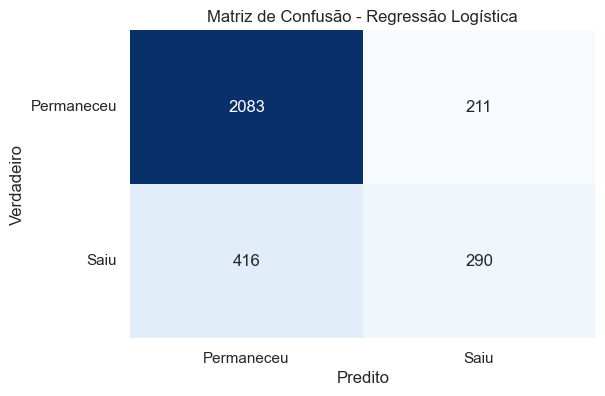

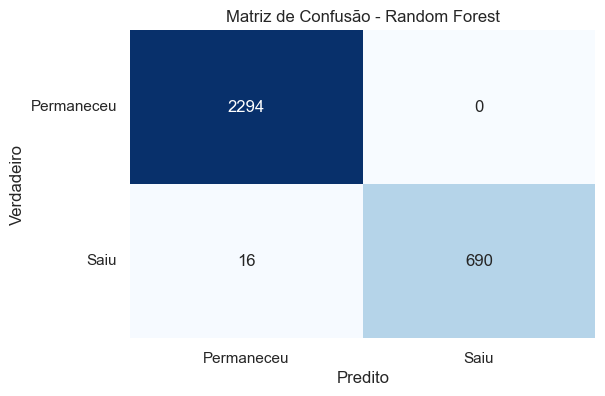

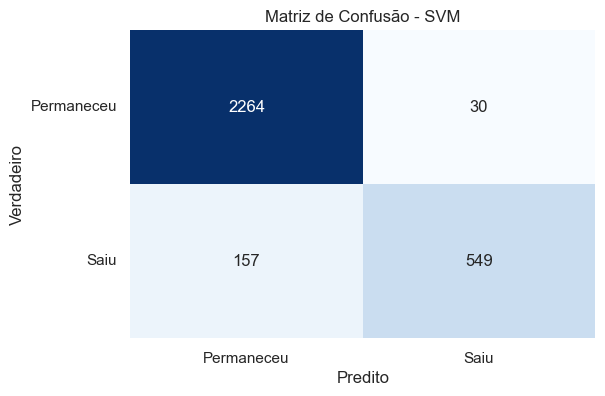

In [101]:
# Matriz de Confusão para cada modelo
for nome_modelo, (y_pred, y_true) in modelos.items():
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Matriz de Confusão - {nome_modelo}')
    plt.xlabel('Predito')
    plt.ylabel('Verdadeiro')
    plt.xticks(ticks=[0.5, 1.5], labels=['Permaneceu', 'Saiu'])
    plt.yticks(ticks=[0.5, 1.5], labels=['Permaneceu', 'Saiu'], rotation=0)
    plt.show()

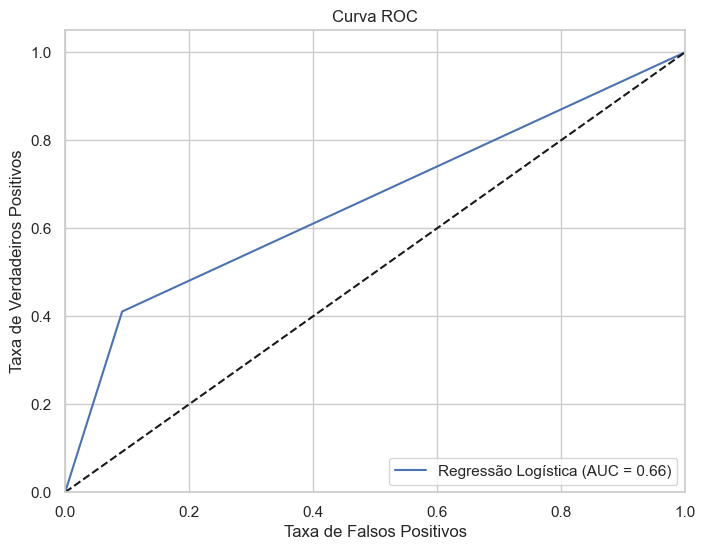

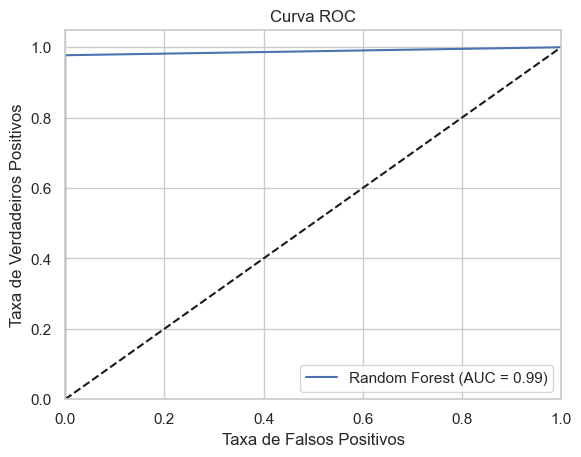

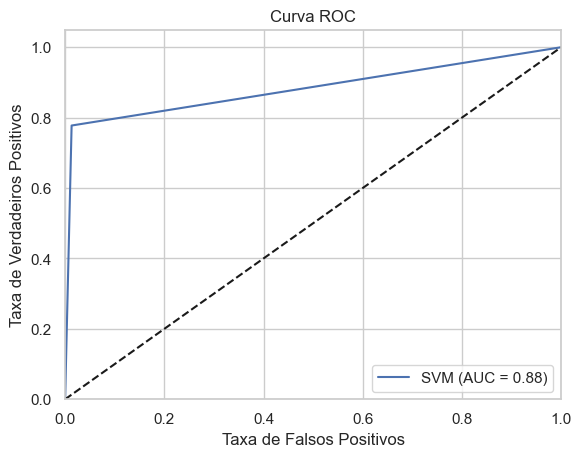

In [ ]:
# ROC AUC para cada modelo
from sklearn.metrics import roc_curve, auc

# Valores do ROC AUC


plt.figure(figsize=(8,6))
for nome_modelo, (y_pred, y_true) in modelos.items():
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{nome_modelo} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')  # Linha diagonal
    plt.xlim([0.0, 1.0])    
    plt.ylim([0.0, 1.05])
    plt.xlabel('Taxa de Falsos Positivos')
    plt.ylabel('Taxa de Verdadeiros Positivos')
    plt.title('Curva ROC')
    plt.legend(loc='lower right')
    plt.show()

# Conclusão

Responder:

Melhor modelo

Principais variáveis

Tipo de erro mais crítico

---

Desafio do Módulo de Machine Learning Avançado - Fase 2. Pós Tech em Data Analytics (FIAP)